In [2]:
import pandas as pd
import sys
import pyfaidx
sys.path.append("/oak/stanford/groups/akundaje/ziwei75/reporterNet/reporterNet/reporterNet/utils/")
sys.path.append("/oak/stanford/groups/akundaje/ziwei75/ALS_colab/script/2023_8_21_shap_score")
import one_hot
import shap_utils
import shap
import tensorflow as tf
import numpy as np
tf.compat.v1.disable_eager_execution()

In [3]:
from tensorflow.keras.models import load_model
cell_type="alpha_control"
fold_number=0/
model = "/oak/stanford/groups/akundaje/ziwei75/ALS_colab/models/2023_8_10/%s/fold%s/models/chrombpnet_nobias.h5"%(cell_type,fold_number)
model = load_model(model)

2024-05-21 21:17:04.424338: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 21:17:05.296940: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10545 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [4]:
def interpret(model, seqs, profile_or_counts):
    print("Seqs dimension : {}".format(seqs.shape))

    outlen = model.output_shape[0][1]

    profile_model_input = model.input
    profile_input = seqs
    counts_model_input = model.input
    counts_input = seqs

    if profile_or_counts == "counts":
        profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
            (counts_model_input, tf.reduce_sum(model.outputs[1], axis=-1)),
            shap_utils.shuffle_several_times,
            combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

        print("Generating 'counts' shap scores")
        counts_shap_scores = profile_model_counts_explainer.shap_values(
            counts_input, progress_message=100)
        return counts_shap_scores
        
    if profile_or_counts == "profile":
        weightedsum_meannormed_logits = shap_utils.get_weightedsum_meannormed_logits(model)
        profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
            (profile_model_input, weightedsum_meannormed_logits),
            shap_utils.shuffle_several_times,
            combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

        print("Generating 'profile' shap scores")
        profile_shap_scores = profile_model_profile_explainer.shap_values(
            profile_input, progress_message=100)    
        return profile_shap_scores

In [8]:
genome="/oak/stanford/groups/akundaje/ziwei75/ref_data/male.hg19.fa"
genome = pyfaidx.Fasta(genome)


In [ ]:
### chr7:76,009,472:C>T

In [33]:
chromo = "chr7"
coord = 76009472-1
seq = genome[chromo][coord-2114//2:coord+2114//2].seq
seq = seq.upper()

In [34]:
ref_seq = seq
alt_seq = seq[:2114//2] + 'T' + seq[2114//2+1:]

In [35]:
len(ref_seq),len(alt_seq)

(2114, 2114)

In [36]:
ref_seq[2114//2],alt_seq[2114//2]
ref_seq=one_hot.dna_to_one_hot([ref_seq])
alt_seq=one_hot.dna_to_one_hot([alt_seq])

In [37]:
ref_predictions = model.predict(ref_seq)
alt_predictions = model.predict(alt_seq)

/users/ziwei75/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-05-21 21:49:46.843852: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


In [43]:
ref_predictions[1],alt_predictions[1]

(array([[6.2733245]], dtype=float32), array([[6.460153]], dtype=float32))

In [45]:
ref_interpretation = interpret(model,ref_seq,"counts")
alt_interpretation = interpret(model,alt_seq,"counts")

Seqs dimension : (1, 2114, 4)

Generating 'counts' shap scores
Done 0 examples of 1
Seqs dimension : (1, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 1


In [46]:
import os

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Helper function to draw a letter within a sequence logo
def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    fp = FontProperties(family="DejaVu Sans", weight="bold")

    globscale = 1.35

    LETTERS = {
        "T": TextPath((-0.305, 0), "T", size=1, prop=fp),
        "G": TextPath((-0.384, 0), "G", size=1, prop=fp),
        "A": TextPath((-0.35, 0), "A", size=1, prop=fp),
        "C": TextPath((-0.366, 0), "C", size=1, prop=fp),
        "UP": TextPath((-0.488, 0), "$\\Uparrow$", size=1, prop=fp),
        "DN": TextPath((-0.488, 0), "$\\Downarrow$", size=1, prop=fp),
        "(": TextPath((-0.25, 0), "(", size=1, prop=fp),
        ".": TextPath((-0.125, 0), "-", size=1, prop=fp),
        ")": TextPath((-0.1, 0), ")", size=1, prop=fp),
    }

    COLOR_SCHEME = {
        "G": "orange",
        "A": "green",
        "C": "blue",
        "T": "red",
        "UP": "green",
        "DN": "red",
        "(": "black",
        ".": "black",
        ")": "black",
    }

    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None:
        chosen_color = color

    t = (
        mpl.transforms.Affine2D().scale(1 * globscale, yscale * globscale)
        + mpl.transforms.Affine2D().translate(x, y)
        + ax.transData
    )
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)

    if ax != None:
        ax.add_artist(p)
    return p

#Function to plot an input-gated sequence logo
def plot_seq_scores(importance_scores, ax, dpi=None, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default"):

    importance_scores = importance_scores.T

#     fig = None
#     if dpi is not None :
#         fig = plt.figure(figsize=figsize, dpi=dpi)
#     else :
#         fig = plt.figure(figsize=figsize)


    ref_seq = ""
    for j in range(importance_scores.shape[1]):
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))

        if argmax_nt == 0:
            ref_seq += "A"
        elif argmax_nt == 1:
            ref_seq += "C"
        elif argmax_nt == 2:
            ref_seq += "G"
        elif argmax_nt == 3:
            ref_seq += "T"

#     ax = plt.gca()

    for i in range(0, len(ref_seq)):
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)

    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.3f"))

    plt.xlim((0, len(ref_seq)))

    # plt.axis('off')

    if plot_y_ticks:
        plt.yticks(fontsize=6)
    else:
        plt.yticks([], [])

    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)
    elif y_min is not None:
        plt.ylim(y_min)
    else:
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores)),
        )

    #plt.axhline(y=0.0, color="black", linestyle="-", linewidth=0.2)

    # for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

#     if save_figs:
#         plt.savefig(fig_name + ".png", transparent=True, dpi=300)
#         plt.savefig(fig_name + ".pdf", dpi=300)



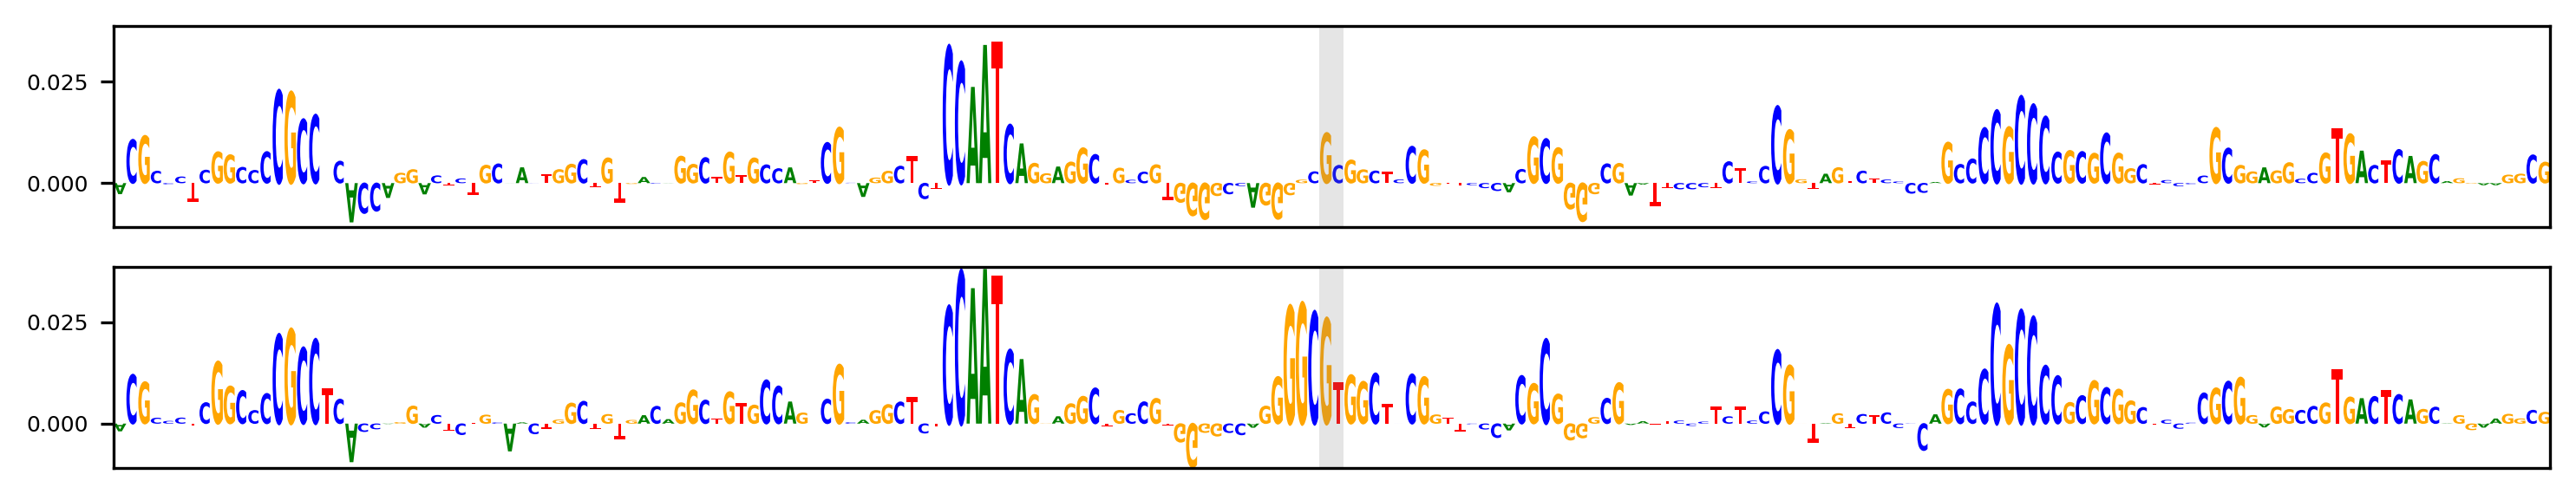

In [54]:
xmin_ = 1057 - 100
xmax_ = 1057 + 100
fig, axes = plt.subplots(2,1,figsize=(10,2), dpi=300)
a1_shap = (ref_interpretation*ref_seq)[:,xmin_:xmax_]
a2_shap = (alt_interpretation*alt_seq)[:,xmin_:xmax_]
plot_seq_scores(a1_shap,axes[0])
plot_seq_scores(a2_shap,axes[1])

ymin_ = min([a1_shap.min(),a2_shap.min()])
ymax_ = max([a1_shap.max(),a2_shap.max()])

rect = patches.Rectangle((1057-xmin_-1, ymin_), 2, ymax_-ymin_, linewidth=1, edgecolor='none', facecolor='grey',alpha=0.2)
axes[0].add_patch(rect)
rect = patches.Rectangle((1057-xmin_-1, ymin_), 2 , ymax_-ymin_, linewidth=1, edgecolor='none', facecolor='grey',alpha=0.2)
axes[1].add_patch(rect)

# axes[0].set_xticks(list(range(0,200,75)), list(range(start,end,75)),size=5)
# axes[1].set_xticks(list(range(0,200,75)), list(range(start,end,75)),size=5)

axes[0].set_ylim([ymin_,ymax_])
axes[1].set_ylim([ymin_,ymax_])

ymin_ = round(ymin_,2)
ymax_ = round(ymax_,2)
# axes[0].set_yticks(list(np.arange(ymin_,ymax_,0.08)),size=5)
# axes[1].set_yticks(list(np.arange(ymin_,ymax_,0.08)),size=5)

plt.show()

